In [77]:
## UofT SCS FinTech Bootcamp Project 1 Team Code
## Project team: Ambreen Simon, George Barbuc, Katie Gouinlock, Keiran Gugula
# Import libraries required for analysis and visualization
from pathlib import Path
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import datetime as dt
import yfinance as yf
import random
from MCForecastTools import MCSimulation
import hvplot.pandas
import numpy as np
import seaborn as sns

%matplotlib inline

In [3]:
# Create dataframe with S&P 500 tickers based on information in CSV file
sp_csv = pd.read_csv(Path("sp500.csv"))

In [4]:
# Keiran can you confirm what this step does ?
tickers = [x for x in sp_csv.loc[:, "Symbol"]]

# Appending SPY ticker to S&P 500 consitutents. SPY will be used as a proxy for S&P 500 returns
tickers.append("SPY")

# Downloading historical price data for S&P 500 securities using Yfinance library
data = yf.download(tickers=tickers, start="2012-01-01", end="2017-01-01", group_by="ticker")

[*********************100%***********************]  506 of 506 completed

10 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- OTIS: Data doesn't exist for startDate = 1325394000, endDate = 1483246800
- CARR: Data doesn't exist for startDate = 1325394000, endDate = 1483246800
- DOW: Data doesn't exist for startDate = 1325394000, endDate = 1483246800
- FOX: Data doesn't exist for startDate = 1325394000, endDate = 1483246800
- CTVA: Data doesn't exist for startDate = 1325394000, endDate = 1483246800
- BRK.B: No data found, symbol may be delisted
- IR: Data doesn't exist for startDate = 1325394000, endDate = 1483246800
- VIAC: Data doesn't exist for startDate = 1325394000, endDate = 1483246800
- FOXA: Data doesn't exist for startDate = 1325394000, endDate = 1483246800


In [5]:
data.head()

L                                                         \
                 Open       High        Low      Close  Adj Close     Volume   
Date                                                                           
2012-01-03  38.480000  38.689999  38.310001  38.470001  36.513683  1350600.0   
2012-01-04  38.220001  38.430000  38.000000  38.000000  36.067581  1651800.0   
2012-01-05  37.860001  38.209999  37.320000  38.049999  36.115044  1090000.0   
2012-01-06  38.130001  38.130001  37.630001  37.720001  35.801819   928800.0   
2012-01-09  37.919998  38.049999  37.680000  37.840000  35.915718  1216800.0   

                 CTAS                                   ...    DFS             \
                 Open       High        Low      Close  ...    Low      Close   
Date                                                    ...                     
2012-01-03  35.570000  35.700001  35.189999  35.240002  ...  24.00  24.209999   
2012-01-04  35.299999  36.540001  35.230000  36.400002  ...  24.00  24.309999   
2012-01-05  36.070000  36.570000  35.860001  36.509998  ...  23.75  24.520000   
2012-01-06  36.509998  37.400002  36.400002  37.310001  ...  24.16  24.299999   
2012-01-09  37.430000  37.470001  36.799999  37.389999  ...  24.25  24.400000   

                                       SBUX                                   \
            Adj Close     Volume       Open       High        Low      Close   
Date                                                                           
2012-01-03  20.377029  4368800.0  23.424999  23.520000  22.639999  22.645000   
2012-01-04  20.461201  5187400.0  22.705000  23.315001  22.639999  23.084999   
2012-01-05  20.637949  4571700.0  23.094999  23.200001  22.775000  23.180000   
2012-01-06  20.452784  3434100.0  23.190001  23.455000  23.115000  23.360001   
2012-01-09  20.536953  3287400.0  23.365000  23.400000  23.135000  23.295000   

                                   
            Adj Close      Volume  
Date                               
2012-01-03  19.476772  12922400.0  
2012-01-04  19.855209  13886800.0  
2012-01-05  19.936920   9731800.0  
2012-01-06  20.091738   8105400.0  
2012-01-09  20.035835   7261600.0  

[5 rows x 3036 columns]

In [6]:
# Creating function in order to clean data downloaded from yfinance library

def clean_yahoo_df(data):
    data.drop(["Open", "High", "Low", "Adj Close", "Volume"], axis=1, level=1, inplace=True)
    df_clean = data.droplevel(axis=1, level=1)
    return df_clean
    
sp_df_clean = clean_yahoo_df(data)
sp_df_clean.head()

,L,CTAS,LOW,MSI,CCL,TIF,DAL,CHTR,TFC,REGN,...,LMT,FAST,KEYS,VRTX,NRG,UDR,BKNG,NVR,DFS,SBUX
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,38.470001,35.240002,25.520000,46.619999,32.959999,66.480003,8.04,57.189999,25.860001,56.430000,...,82.019997,21.879999,NaN,32.230000,17.969999,25.200001,485.149994,703.159973,24.209999,22.645000
2012-01-04,38.000000,36.400002,26.469999,46.360001,33.220001,66.790001,8.01,56.810001,25.920000,57.830002,...,80.910004,22.180000,NaN,32.200001,17.980000,24.940001,480.910004,705.010010,24.309999,23.084999
2012-01-05,38.049999,36.509998,26.370001,46.669998,33.270000,66.680000,8.33,56.980000,26.170000,60.939999,...,80.070000,22.565001,NaN,33.119999,18.049999,24.990000,486.209991,715.000000,24.520000,23.180000
2012-01-06,37.720001,37.310001,26.340000,46.549999,32.910000,65.750000,8.32,56.619999,25.790001,65.790001,...,79.980003,22.605000,NaN,34.049999,17.690001,24.670000,480.309998,711.630005,24.299999,23.360001
2012-01-09,37.840000,37.389999,26.100000,46.180000,33.080002,66.940002,8.28,56.750000,26.400000,65.480003,...,80.040001,22.584999,NaN,35.680000,17.540001,24.389999,476.079987,712.559998,24.400000,23.295000


In [7]:
# Storing cleaned data from yfinance to a new dataframe
sp_df_clean.to_csv("sp500_raw_data.csv")

In [8]:
# Creating a new dataframe from the cleaned yfinance S&P 500 data, setting index as the date
sp_path = Path("sp500_raw_data.csv")
sp_combined_df = pd.read_csv(sp_path, index_col='Date',infer_datetime_format=True,parse_dates=True)
sp_combined_df.head(5)

,L,CTAS,LOW,MSI,CCL,TIF,DAL,CHTR,TFC,REGN,...,LMT,FAST,KEYS,VRTX,NRG,UDR,BKNG,NVR,DFS,SBUX
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,38.470001,35.240002,25.520000,46.619999,32.959999,66.480003,8.04,57.189999,25.860001,56.430000,...,82.019997,21.879999,NaN,32.230000,17.969999,25.200001,485.149994,703.159973,24.209999,22.645000
2012-01-04,38.000000,36.400002,26.469999,46.360001,33.220001,66.790001,8.01,56.810001,25.920000,57.830002,...,80.910004,22.180000,NaN,32.200001,17.980000,24.940001,480.910004,705.010010,24.309999,23.084999
2012-01-05,38.049999,36.509998,26.370001,46.669998,33.270000,66.680000,8.33,56.980000,26.170000,60.939999,...,80.070000,22.565001,NaN,33.119999,18.049999,24.990000,486.209991,715.000000,24.520000,23.180000
2012-01-06,37.720001,37.310001,26.340000,46.549999,32.910000,65.750000,8.32,56.619999,25.790001,65.790001,...,79.980003,22.605000,NaN,34.049999,17.690001,24.670000,480.309998,711.630005,24.299999,23.360001
2012-01-09,37.840000,37.389999,26.100000,46.180000,33.080002,66.940002,8.28,56.750000,26.400000,65.480003,...,80.040001,22.584999,NaN,35.680000,17.540001,24.389999,476.079987,712.559998,24.400000,23.295000


In [9]:
## Commencing data cleaning procedures
# Check to confirm whether there are any duplicates in the index variable
sp_combined_df.duplicated()

Date
2012-01-03    False
2012-01-04    False
2012-01-05    False
2012-01-06    False
2012-01-09    False
2012-01-10    False
2012-01-11    False
2012-01-12    False
2012-01-13    False
2012-01-17    False
2012-01-18    False
2012-01-19    False
2012-01-20    False
2012-01-23    False
2012-01-24    False
2012-01-25    False
2012-01-26    False
2012-01-27    False
2012-01-30    False
2012-01-31    False
2012-02-01    False
2012-02-02    False
2012-02-03    False
2012-02-06    False
2012-02-07    False
2012-02-08    False
2012-02-09    False
2012-02-10    False
2012-02-13    False
2012-02-14    False
              ...  
2016-11-17    False
2016-11-18    False
2016-11-21    False
2016-11-22    False
2016-11-23    False
2016-11-25    False
2016-11-28    False
2016-11-29    False
2016-11-30    False
2016-12-01    False
2016-12-02    False
2016-12-05    False
2016-12-06    False
2016-12-07    False
2016-12-08    False
2016-12-09    False
2016-12-12    False
2016-12-13    False
2016-12-14    F

In [10]:
# Writing data to a csv file for future use
sp_combined_df.to_csv("sp500_clean.csv")

In [11]:
# Reading in data from csv file and continuing cleaning procedures, beginning first with visualizing data
sp_csv_clean = pd.read_csv(Path("sp500_clean.csv"),index_col='Date',infer_datetime_format=True,parse_dates=True)
sp_csv_clean.head()

,L,CTAS,LOW,MSI,CCL,TIF,DAL,CHTR,TFC,REGN,...,LMT,FAST,KEYS,VRTX,NRG,UDR,BKNG,NVR,DFS,SBUX
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,38.470001,35.240002,25.520000,46.619999,32.959999,66.480003,8.04,57.189999,25.860001,56.430000,...,82.019997,21.879999,NaN,32.230000,17.969999,25.200001,485.149994,703.159973,24.209999,22.645000
2012-01-04,38.000000,36.400002,26.469999,46.360001,33.220001,66.790001,8.01,56.810001,25.920000,57.830002,...,80.910004,22.180000,NaN,32.200001,17.980000,24.940001,480.910004,705.010010,24.309999,23.084999
2012-01-05,38.049999,36.509998,26.370001,46.669998,33.270000,66.680000,8.33,56.980000,26.170000,60.939999,...,80.070000,22.565001,NaN,33.119999,18.049999,24.990000,486.209991,715.000000,24.520000,23.180000
2012-01-06,37.720001,37.310001,26.340000,46.549999,32.910000,65.750000,8.32,56.619999,25.790001,65.790001,...,79.980003,22.605000,NaN,34.049999,17.690001,24.670000,480.309998,711.630005,24.299999,23.360001
2012-01-09,37.840000,37.389999,26.100000,46.180000,33.080002,66.940002,8.28,56.750000,26.400000,65.480003,...,80.040001,22.584999,NaN,35.680000,17.540001,24.389999,476.079987,712.559998,24.400000,23.295000


In [12]:
# Confirming number of entries in data frame
sp_csv_clean.shape

(1260, 506)

In [13]:
# Checking for null values
sp_csv_clean.isnull().sum()

L          2
CTAS       2
LOW        2
MSI        2
CCL        2
TIF        2
DAL        2
CHTR       2
TFC        2
REGN       2
CFG      687
KMB        2
KO         2
GRMN       2
UPS        2
XRAY       2
EIX        2
MO         2
EVRG       2
VLO        2
LHX        2
DVN        2
GILD       2
CSX        2
RTX        2
BAX        2
QCOM       2
DHI        2
HBAN       2
AWK        2
        ... 
KMI        2
CERN       2
AME        2
XEL        2
UNP        2
HLT      491
NTRS       2
TSCO       2
LW      1225
MDLZ       2
ECL        2
CF         2
AEE        2
AOS        2
CMG        2
AEP        2
SRE        2
ICE        2
DGX        2
AVY        2
LMT        2
FAST       2
KEYS     705
VRTX       2
NRG        2
UDR        2
BKNG       2
NVR        2
DFS        2
SBUX       2
Length: 506, dtype: int64

In [14]:
# Further exploring data frame in preparation for cleaning of data
sp_csv_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1260 entries, 2012-01-03 to 2016-12-30
Columns: 506 entries, L to SBUX
dtypes: float64(506)
memory usage: 4.9 MB


In [15]:
# Confirming data types in dataframe are all float values
sp_csv_clean.dtypes

L       float64
CTAS    float64
LOW     float64
MSI     float64
CCL     float64
TIF     float64
DAL     float64
CHTR    float64
TFC     float64
REGN    float64
CFG     float64
KMB     float64
KO      float64
GRMN    float64
UPS     float64
XRAY    float64
EIX     float64
MO      float64
EVRG    float64
VLO     float64
LHX     float64
DVN     float64
GILD    float64
CSX     float64
RTX     float64
BAX     float64
QCOM    float64
DHI     float64
HBAN    float64
AWK     float64
         ...   
KMI     float64
CERN    float64
AME     float64
XEL     float64
UNP     float64
HLT     float64
NTRS    float64
TSCO    float64
LW      float64
MDLZ    float64
ECL     float64
CF      float64
AEE     float64
AOS     float64
CMG     float64
AEP     float64
SRE     float64
ICE     float64
DGX     float64
AVY     float64
LMT     float64
FAST    float64
KEYS    float64
VRTX    float64
NRG     float64
UDR     float64
BKNG    float64
NVR     float64
DFS     float64
SBUX    float64
Length: 506, dtype: obje

In [16]:
# Confirming maximum amount of data, i.e. number of trading days
# that will be included in the period is 1258
sp_csv_clean.count()

L       1258
CTAS    1258
LOW     1258
MSI     1258
CCL     1258
TIF     1258
DAL     1258
CHTR    1258
TFC     1258
REGN    1258
CFG      573
KMB     1258
KO      1258
GRMN    1258
UPS     1258
XRAY    1258
EIX     1258
MO      1258
EVRG    1258
VLO     1258
LHX     1258
DVN     1258
GILD    1258
CSX     1258
RTX     1258
BAX     1258
QCOM    1258
DHI     1258
HBAN    1258
AWK     1258
        ... 
KMI     1258
CERN    1258
AME     1258
XEL     1258
UNP     1258
HLT      769
NTRS    1258
TSCO    1258
LW        35
MDLZ    1258
ECL     1258
CF      1258
AEE     1258
AOS     1258
CMG     1258
AEP     1258
SRE     1258
ICE     1258
DGX     1258
AVY     1258
LMT     1258
FAST    1258
KEYS     555
VRTX    1258
NRG     1258
UDR     1258
BKNG    1258
NVR     1258
DFS     1258
SBUX    1258
Length: 506, dtype: int64

In [17]:
# Checking for null values in data set (anticipate there will be some)
# with stocks that were not present in the S&P 500 for the full time, as well as 2 days of blank trading data previously identified

sp_csv_clean.isnull()

,L,CTAS,LOW,MSI,CCL,TIF,DAL,CHTR,TFC,REGN,...,LMT,FAST,KEYS,VRTX,NRG,UDR,BKNG,NVR,DFS,SBUX
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2012-01-04,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2012-01-05,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2012-01-06,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2012-01-09,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2012-01-10,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2012-01-11,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2012-01-12,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2012-01-13,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False


In [18]:
#Checking for nulls
sp_csv_clean.isnull().mean() *100

L        0.158730
CTAS     0.158730
LOW      0.158730
MSI      0.158730
CCL      0.158730
TIF      0.158730
DAL      0.158730
CHTR     0.158730
TFC      0.158730
REGN     0.158730
CFG     54.523810
KMB      0.158730
KO       0.158730
GRMN     0.158730
UPS      0.158730
XRAY     0.158730
EIX      0.158730
MO       0.158730
EVRG     0.158730
VLO      0.158730
LHX      0.158730
DVN      0.158730
GILD     0.158730
CSX      0.158730
RTX      0.158730
BAX      0.158730
QCOM     0.158730
DHI      0.158730
HBAN     0.158730
AWK      0.158730
          ...    
KMI      0.158730
CERN     0.158730
AME      0.158730
XEL      0.158730
UNP      0.158730
HLT     38.968254
NTRS     0.158730
TSCO     0.158730
LW      97.222222
MDLZ     0.158730
ECL      0.158730
CF       0.158730
AEE      0.158730
AOS      0.158730
CMG      0.158730
AEP      0.158730
SRE      0.158730
ICE      0.158730
DGX      0.158730
AVY      0.158730
LMT      0.158730
FAST     0.158730
KEYS    55.952381
VRTX     0.158730
NRG      0

In [19]:
# Dropping all rows with morethan two null values, threshold prevents us from dropping entire data set as a result of two trading days of missning data
df_all_no_null=sp_csv_clean.dropna(thresh=2).copy()

In [23]:
# Drop those tickers that do not have complete price history for the 2012 to 2017 time fram in scope for analysis
df_all_clean = df_all_no_null.dropna(axis=1)
df_all_clean.head()

,L,CTAS,LOW,MSI,CCL,TIF,DAL,CHTR,TFC,REGN,...,AVY,LMT,FAST,VRTX,NRG,UDR,BKNG,NVR,DFS,SBUX
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,38.470001,35.240002,25.520000,46.619999,32.959999,66.480003,8.04,57.189999,25.860001,56.430000,...,29.309999,82.019997,21.879999,32.230000,17.969999,25.200001,485.149994,703.159973,24.209999,22.645000
2012-01-04,38.000000,36.400002,26.469999,46.360001,33.220001,66.790001,8.01,56.810001,25.920000,57.830002,...,29.430000,80.910004,22.180000,32.200001,17.980000,24.940001,480.910004,705.010010,24.309999,23.084999
2012-01-05,38.049999,36.509998,26.370001,46.669998,33.270000,66.680000,8.33,56.980000,26.170000,60.939999,...,29.230000,80.070000,22.565001,33.119999,18.049999,24.990000,486.209991,715.000000,24.520000,23.180000
2012-01-06,37.720001,37.310001,26.340000,46.549999,32.910000,65.750000,8.32,56.619999,25.790001,65.790001,...,29.590000,79.980003,22.605000,34.049999,17.690001,24.670000,480.309998,711.630005,24.299999,23.360001
2012-01-09,37.840000,37.389999,26.100000,46.180000,33.080002,66.940002,8.28,56.750000,26.400000,65.480003,...,29.459999,80.040001,22.584999,35.680000,17.540001,24.389999,476.079987,712.559998,24.400000,23.295000


In [24]:
# Confirm cleanse of data worked by re-running check for null values
df_all_clean.isnull().sum()

L       0
CTAS    0
LOW     0
MSI     0
CCL     0
TIF     0
DAL     0
CHTR    0
TFC     0
REGN    0
KMB     0
KO      0
GRMN    0
UPS     0
XRAY    0
EIX     0
MO      0
EVRG    0
VLO     0
LHX     0
DVN     0
GILD    0
CSX     0
RTX     0
BAX     0
QCOM    0
DHI     0
HBAN    0
AWK     0
APH     0
       ..
ADP     0
PBCT    0
SWK     0
KMI     0
CERN    0
AME     0
XEL     0
UNP     0
NTRS    0
TSCO    0
MDLZ    0
ECL     0
CF      0
AEE     0
AOS     0
CMG     0
AEP     0
SRE     0
ICE     0
DGX     0
AVY     0
LMT     0
FAST    0
VRTX    0
NRG     0
UDR     0
BKNG    0
NVR     0
DFS     0
SBUX    0
Length: 465, dtype: int64

In [25]:
df_all_clean.head()

,L,CTAS,LOW,MSI,CCL,TIF,DAL,CHTR,TFC,REGN,...,AVY,LMT,FAST,VRTX,NRG,UDR,BKNG,NVR,DFS,SBUX
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,38.470001,35.240002,25.520000,46.619999,32.959999,66.480003,8.04,57.189999,25.860001,56.430000,...,29.309999,82.019997,21.879999,32.230000,17.969999,25.200001,485.149994,703.159973,24.209999,22.645000
2012-01-04,38.000000,36.400002,26.469999,46.360001,33.220001,66.790001,8.01,56.810001,25.920000,57.830002,...,29.430000,80.910004,22.180000,32.200001,17.980000,24.940001,480.910004,705.010010,24.309999,23.084999
2012-01-05,38.049999,36.509998,26.370001,46.669998,33.270000,66.680000,8.33,56.980000,26.170000,60.939999,...,29.230000,80.070000,22.565001,33.119999,18.049999,24.990000,486.209991,715.000000,24.520000,23.180000
2012-01-06,37.720001,37.310001,26.340000,46.549999,32.910000,65.750000,8.32,56.619999,25.790001,65.790001,...,29.590000,79.980003,22.605000,34.049999,17.690001,24.670000,480.309998,711.630005,24.299999,23.360001
2012-01-09,37.840000,37.389999,26.100000,46.180000,33.080002,66.940002,8.28,56.750000,26.400000,65.480003,...,29.459999,80.040001,22.584999,35.680000,17.540001,24.389999,476.079987,712.559998,24.400000,23.295000


In [26]:
# Save cleaned data to a new csv for further analysis
df_all_clean.to_csv("final_clean_df.csv")

In [27]:
# Create new dataframe with daily returns based on S&P 500 price data
daily_returns = df_all_clean.pct_change()

# Drop first row which is null following conversion to returns
daily_returns.dropna().copy()
daily_returns.head()

,L,CTAS,LOW,MSI,CCL,TIF,DAL,CHTR,TFC,REGN,...,AVY,LMT,FAST,VRTX,NRG,UDR,BKNG,NVR,DFS,SBUX
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-04,-0.012217,0.032917,0.037226,-0.005577,0.007888,0.004663,-0.003731,-0.006644,0.002320,0.024810,...,0.004094,-0.013533,0.013711,-0.000931,0.000556,-0.010317,-0.008740,0.002631,0.004131,0.019430
2012-01-05,0.001316,0.003022,-0.003778,0.006687,0.001505,-0.001647,0.039950,0.002992,0.009645,0.053778,...,-0.006796,-0.010382,0.017358,0.028571,0.003893,0.002005,0.011021,0.014170,0.008638,0.004115
2012-01-06,-0.008673,0.021912,-0.001138,-0.002571,-0.010821,-0.013947,-0.001201,-0.006318,-0.014520,0.079587,...,0.012316,-0.001124,0.001773,0.028080,-0.019945,-0.012805,-0.012135,-0.004713,-0.008972,0.007765
2012-01-09,0.003181,0.002144,-0.009112,-0.007948,0.005166,0.018099,-0.004808,0.002296,0.023653,-0.004712,...,-0.004393,0.000750,-0.000885,0.047871,-0.008479,-0.011350,-0.008807,0.001307,0.004115,-0.002783


In [30]:
# Create function find_beta to calculate beta for each ticker and store the result in a dictionary

def find_beta(df):

    index_returns = df.loc[:,"SPY"]
    df_beta = {}
    
    for ticker in df:
        covariance = df[ticker].cov(index_returns)
        variance = df[ticker].var()
        beta = covariance/variance
        df_beta[ticker] = beta
    
    return df_beta



In [31]:
# Calculate and store betas in a dictionary for each ticker in the daily returns data (S&P 500 + SPY)
beta = find_beta(daily_returns)


In [32]:
# Create df with beta values, sort in descending order, and print output to validate calculations
beta_df = pd.DataFrame.from_dict(beta, orient="index")
beta_df = beta_df.rename(columns={0: "Beta"})
beta_df = beta_df.sort_values(["Beta"],ascending=False)
beta_df.tail()

,Beta
ABMD,0.080537
VRTX,0.076337
AMD,0.075600
NFLX,0.066765
NEM,0.050987


In [33]:
# Start construction of high and low vol portfolios, by transposting daily returns data and sorting by t
daily_returns_transposed = df_all_clean.transpose()
daily_returns_transposed.sort_index(ascending=True)

Date,2012-01-03 00:00:00,2012-01-04 00:00:00,2012-01-05 00:00:00,2012-01-06 00:00:00,2012-01-09 00:00:00,2012-01-10 00:00:00,2012-01-11 00:00:00,2012-01-12 00:00:00,2012-01-13 00:00:00,2012-01-17 00:00:00,...,2016-12-16 00:00:00,2016-12-19 00:00:00,2016-12-20 00:00:00,2016-12-21 00:00:00,2016-12-22 00:00:00,2016-12-23 00:00:00,2016-12-27 00:00:00,2016-12-28 00:00:00,2016-12-29 00:00:00,2016-12-30 00:00:00
A,26.094421,25.886982,26.466381,26.752504,27.453505,27.968527,27.839771,28.268955,27.939915,28.605150,...,45.910000,45.430000,46.209999,46.040001,45.970001,46.200001,46.509998,45.720001,45.639999,45.560001
AAL,5.120000,5.030000,5.470000,5.600000,5.720000,5.720000,5.910000,6.050000,5.970000,5.880000,...,47.630001,48.580002,49.220001,49.470001,48.689999,48.480000,48.610001,47.669998,47.250000,46.689999
AAP,69.099998,70.720001,71.169998,71.500000,71.480003,71.540001,72.019997,71.650002,71.459999,72.080002,...,171.910004,173.820007,175.630005,173.509995,170.389999,170.889999,171.839996,170.419998,170.279999,169.119995
AAPL,14.686786,14.765715,14.929643,15.085714,15.061786,15.115714,15.091071,15.049643,14.993215,15.167857,...,28.992500,29.160000,29.237499,29.264999,29.072500,29.129999,29.315001,29.190001,29.182501,28.955000
ABC,38.070000,38.200001,38.490002,38.590000,38.570000,39.009998,38.610001,38.840000,37.799999,38.299999,...,77.379997,78.419998,79.300003,78.849998,77.809998,78.559998,78.820000,78.349998,79.339996,78.190002
ABMD,18.250000,18.110001,18.270000,18.139999,18.209999,18.160000,18.240000,18.320000,17.980000,18.049999,...,117.540001,116.769997,113.099998,113.559998,111.550003,112.379997,113.739998,112.779999,113.580002,112.680000
ABT,27.214256,27.108700,27.046326,26.801628,26.796829,26.921577,26.590515,26.465769,26.595314,26.729658,...,38.099998,38.340000,38.189999,38.240002,38.290001,38.419998,38.599998,38.220001,38.310001,38.410000
ACN,52.950001,52.930000,51.919998,51.830002,51.740002,52.630001,53.669998,53.939999,53.250000,53.490002,...,123.000000,123.650002,124.099998,117.900002,117.790001,117.480003,117.550003,116.610001,117.010002,117.129997
ADBE,28.570000,28.280001,28.480000,28.719999,28.530001,29.200001,29.320000,29.230000,28.969999,29.350000,...,103.550003,105.290001,105.769997,105.510002,104.720001,105.019997,104.980003,103.769997,103.680000,102.949997
ADI,36.029999,35.980000,36.139999,35.900002,36.599998,36.759998,36.910000,37.310001,36.619999,37.040001,...,72.089996,72.809998,73.400002,73.599998,73.449997,73.839996,74.309998,73.559998,73.580002,72.620003


In [34]:
# Confirm shape including # of rows (and therefore unique tickers) in daily returns dataframe
daily_returns_transposed.shape

(465, 1258)

In [48]:
# Sort dataframe by ticker and confirm # of rows (and therefore unique tickers)
beta_df = beta_df.sort_index(ascending=True)
beta_df.head()

,Beta
A,0.373246
AAL,0.118791
AAP,0.191819
AAPL,0.244713
ABC,0.291904


In [50]:
# Merge beta information with daily returns in order to assign a calculated beta to each of the stock tickers in the dataset
df_returns_w_beta = pd.concat([beta_df, daily_returns_transposed], join="inner", axis=1)
df_returns_w_beta.head()

,Beta,2012-01-03 00:00:00,2012-01-04 00:00:00,2012-01-05 00:00:00,2012-01-06 00:00:00,2012-01-09 00:00:00,2012-01-10 00:00:00,2012-01-11 00:00:00,2012-01-12 00:00:00,2012-01-13 00:00:00,...,2016-12-16 00:00:00,2016-12-19 00:00:00,2016-12-20 00:00:00,2016-12-21 00:00:00,2016-12-22 00:00:00,2016-12-23 00:00:00,2016-12-27 00:00:00,2016-12-28 00:00:00,2016-12-29 00:00:00,2016-12-30 00:00:00
A,0.373246,26.094421,25.886982,26.466381,26.752504,27.453505,27.968527,27.839771,28.268955,27.939915,...,45.910000,45.430000,46.209999,46.040001,45.970001,46.200001,46.509998,45.720001,45.639999,45.560001
AAL,0.118791,5.120000,5.030000,5.470000,5.600000,5.720000,5.720000,5.910000,6.050000,5.970000,...,47.630001,48.580002,49.220001,49.470001,48.689999,48.480000,48.610001,47.669998,47.250000,46.689999
AAP,0.191819,69.099998,70.720001,71.169998,71.500000,71.480003,71.540001,72.019997,71.650002,71.459999,...,171.910004,173.820007,175.630005,173.509995,170.389999,170.889999,171.839996,170.419998,170.279999,169.119995
AAPL,0.244713,14.686786,14.765715,14.929643,15.085714,15.061786,15.115714,15.091071,15.049643,14.993215,...,28.992500,29.160000,29.237499,29.264999,29.072500,29.129999,29.315001,29.190001,29.182501,28.955000
ABC,0.291904,38.070000,38.200001,38.490002,38.590000,38.570000,39.009998,38.610001,38.840000,37.799999,...,77.379997,78.419998,79.300003,78.849998,77.809998,78.559998,78.820000,78.349998,79.339996,78.190002


In [51]:
# Sort values from low to high beta in preparation for creating low and high beta portfolios
df_returns_w_beta = df_returns_w_beta.sort_values(["Beta"])
df_returns_w_beta.head()

,Beta,2012-01-03 00:00:00,2012-01-04 00:00:00,2012-01-05 00:00:00,2012-01-06 00:00:00,2012-01-09 00:00:00,2012-01-10 00:00:00,2012-01-11 00:00:00,2012-01-12 00:00:00,2012-01-13 00:00:00,...,2016-12-16 00:00:00,2016-12-19 00:00:00,2016-12-20 00:00:00,2016-12-21 00:00:00,2016-12-22 00:00:00,2016-12-23 00:00:00,2016-12-27 00:00:00,2016-12-28 00:00:00,2016-12-29 00:00:00,2016-12-30 00:00:00
NEM,0.050987,62.080002,61.889999,62.099998,61.970001,61.480000,62.650002,63.340000,64.040001,63.389999,...,31.660000,31.780001,31.660000,31.549999,31.440001,32.459999,32.590000,32.779999,35.270000,34.070000
NFLX,0.066765,10.320000,11.492857,11.328571,12.327143,14.025714,13.690000,13.164286,13.164286,13.482857,...,124.220001,125.449997,125.120003,126.500000,125.580002,125.589996,128.350006,125.889999,125.330002,123.800003
AMD,0.075600,5.480000,5.460000,5.460000,5.430000,5.590000,5.710000,5.810000,5.820000,5.660000,...,10.660000,10.950000,11.510000,11.470000,11.600000,11.580000,12.070000,11.550000,11.590000,11.340000
VRTX,0.076337,32.230000,32.200001,33.119999,34.049999,35.680000,36.320000,37.320000,37.070000,36.810001,...,76.800003,76.300003,76.440002,72.599998,72.019997,74.309998,75.190002,74.589996,74.440002,73.669998
ABMD,0.080537,18.250000,18.110001,18.270000,18.139999,18.209999,18.160000,18.240000,18.320000,17.980000,...,117.540001,116.769997,113.099998,113.559998,111.550003,112.379997,113.739998,112.779999,113.580002,112.680000


In [52]:
# Creating two portfolios, one with stocks with the highest 50 betas, the other with the lowest 50 betas
low_vol_port = df_returns_w_beta.head(50)
high_vol_port = df_returns_w_beta.tail(50)

In [53]:
# Once portfolio has been selected, drop beta value, as it is no longer required in order to perform portfolio analysis
low_vol_no_beta = low_vol_port.drop(columns=["Beta"])
high_vol_no_beta = high_vol_port.drop(columns=["Beta"])

In [54]:
# Re-orienting portfolio dataframes in order to have data as a column and tickers as rows
low_vol = low_vol_no_beta.transpose()
high_vol = high_vol_no_beta.transpose()

In [55]:
# Dropping first row of null values (Jan 3 data) to create final high and low beta porfolios
low_vol.dropna(inplace=True)
high_vol.dropna(inplace=True)

In [56]:
# Creating a portfolio with just "SPY US EQUITY" which will function as a proxy for the S&P 500 index return
index_port = df_all_clean["SPY"].to_frame()
#index_port.dropna(inplace=True)
index_port.head()

,SPY
Date,
2012-01-03,127.500000
2012-01-04,127.699997
2012-01-05,128.039993
2012-01-06,127.709999
2012-01-09,128.020004


In [57]:
# Generating fourth portfolio of randomly chosen symbols
rand_port = df_all_clean.sample(n=50,axis='columns')
rand_port.dropna(inplace=True)

In [58]:
## Running Montecarlo simulation on different portfolios
low_vol_MC=pd.concat([low_vol],axis=1,keys=['close']).swaplevel(0,1,1)
high_vol_MC=pd.concat([high_vol],axis=1,keys=['close']).swaplevel(0,1,1)
rand_port_MC=pd.concat([rand_port],axis=1,keys=['close']).swaplevel(0,1,1)
index_port_MC=pd.concat([index_port],axis=1,keys=['close']).swaplevel(0,1,1)

In [59]:
index_port_MC.head()

,SPY
,close
Date,
2012-01-03,127.500000
2012-01-04,127.699997
2012-01-05,128.039993
2012-01-06,127.709999
2012-01-09,128.020004


In [63]:
# Monte Carlo Simulation
num_sims=500

MC_low_vol = MCSimulation(
    portfolio_data = low_vol_MC,
    num_simulation = num_sims,
    num_trading_days = 252*2
)
MC_low_vol.calc_cumulative_return()


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.997690,0.992738,1.003792,0.996158,1.006171,0.998010,0.999647,1.000721,1.002378,0.993762,...,1.000868,1.005257,1.001514,0.999755,1.002037,0.995867,1.003919,1.001279,1.011940,1.000102
2,1.000249,0.993772,1.007369,0.998243,1.012375,1.005870,0.999464,1.002899,1.000154,0.994576,...,1.001197,1.008990,1.001955,1.004595,1.007136,0.995592,1.000513,0.999397,1.010254,0.996831
3,1.001367,0.999388,1.010219,1.001287,1.013332,1.008979,1.007297,1.001659,0.997553,0.997048,...,0.998385,1.016176,1.005032,1.006012,1.010735,0.992570,1.002032,1.002421,1.009580,0.993866
4,0.996332,1.003055,1.010077,1.007317,1.010811,1.007155,1.009454,1.003743,1.005195,1.005273,...,1.000674,1.018596,1.004710,1.007584,1.012927,0.989273,1.004988,0.999797,1.010794,0.993455
5,0.991375,0.999457,1.006059,1.006344,1.017424,1.004122,1.016006,1.007635,1.001844,1.008350,...,1.003857,1.016254,1.009491,1.009005,1.012578,0.989030,1.005132,0.996027,1.006289,0.997191
6,0.993261,1.002970,1.008418,1.009591,1.022316,1.005405,1.013863,1.012150,0.997672,1.003048,...,1.010647,1.023860,1.009394,1.014677,1.019359,0.989074,1.008693,0.997498,1.004885,0.996768
7,0.988289,1.001737,1.002467,1.003617,1.022388,1.004886,1.018530,1.009470,0.995459,1.004847,...,1.010415,1.030486,1.012398,1.007648,1.025247,0.984052,1.004332,0.991854,1.008613,0.997493
8,0.989744,1.002560,1.004572,1.008390,1.024561,1.003370,1.015072,1.010558,0.991463,1.004878,...,1.014734,1.028912,1.009031,1.010225,1.021868,0.979893,1.007174,0.993771,1.005746,1.002092
9,0.997109,1.007323,1.002713,1.011586,1.024231,1.002874,1.013449,1.014271,0.997774,1.005374,...,1.016007,1.027064,1.007803,1.008852,1.023498,0.976663,1.010951,0.994244,1.007341,1.005003


In [64]:
MC_high_vol = MCSimulation(
    portfolio_data = high_vol_MC,
    num_simulation = num_sims,
    num_trading_days = 252*2
)
MC_high_vol.calc_cumulative_return()


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.998789,0.999516,0.998761,1.000571,0.998418,0.999401,1.004386,1.001879,1.002339,0.997747,...,1.000122,1.001829,1.001364,1.001888,1.001576,0.999686,1.000364,0.998992,0.999844,1.000020
2,1.001945,0.999429,0.999618,1.001311,1.000181,0.999998,1.007566,1.000490,1.001283,0.998306,...,1.001297,1.003034,1.001223,1.002026,1.002506,1.001636,1.001071,0.997991,1.002364,1.002697
3,1.000494,0.998259,1.000242,1.000370,1.003029,1.001295,1.008841,1.001686,1.002953,0.999412,...,1.003069,1.002146,1.002652,1.003302,1.003047,1.002811,0.999218,0.997497,1.003250,1.003024
4,1.001764,0.998615,1.000196,1.000585,1.002088,1.000377,1.006753,1.004261,1.005290,0.998885,...,1.002082,0.999581,1.004419,1.002045,1.002490,1.000359,0.999165,0.998075,1.000455,1.007268
5,1.001035,0.999763,0.999477,1.001151,1.002896,1.001228,1.007013,1.003320,1.005831,0.998530,...,1.005555,0.999672,1.005567,1.000610,1.002275,0.999301,0.997935,1.002295,1.000470,1.006358
6,1.002532,0.999262,1.001850,1.000866,1.002392,1.001579,1.008517,1.004256,1.003968,0.999668,...,1.009145,0.999265,1.008533,1.002062,1.000232,1.000329,1.000256,1.003278,1.001671,1.005475
7,1.005840,0.998944,1.004382,1.003344,1.004922,1.003845,1.010642,1.006251,1.005828,1.000464,...,1.011803,1.000968,1.006249,1.000490,0.998233,1.003427,0.998188,1.004542,1.002731,1.006780
8,1.007387,0.999391,1.005287,1.003706,1.004568,1.004348,1.007199,1.007587,1.005241,1.002114,...,1.013694,1.001014,1.007394,0.999802,1.000465,1.002111,1.001539,1.005670,1.003950,1.004949
9,1.008235,0.997791,1.006132,1.004497,1.003792,1.006560,1.011307,1.008483,1.005258,1.002341,...,1.011569,1.000287,1.008215,1.000437,1.003895,0.999910,1.002019,1.008126,1.004868,1.005329


In [65]:
MC_rand_port = MCSimulation(
    portfolio_data = rand_port_MC,
    num_simulation = num_sims,
    num_trading_days = 252*2
)
MC_rand_port.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.001652,0.999956,1.000782,0.999921,1.000095,1.004550,0.998787,0.998621,1.004781,0.998085,...,0.998408,1.002467,1.001373,1.003133,0.999163,0.999933,1.003677,0.998755,1.001663,0.999122
2,1.006220,1.002271,0.997968,0.999200,1.000207,1.007117,0.995912,0.999995,1.006301,1.001140,...,0.997760,1.005051,1.004076,1.002994,0.997478,0.999370,1.003457,0.999995,1.000190,0.998300
3,1.009382,1.000109,1.002685,1.001846,0.999849,1.006505,0.995577,1.000585,1.009016,0.999902,...,0.998483,1.007941,1.003187,1.001863,1.000024,0.999136,1.002937,1.001500,1.002232,0.997499
4,1.010063,0.997136,1.001676,1.005785,1.001870,1.007298,0.998285,1.003923,1.009620,1.001581,...,1.002395,1.008337,1.008364,1.007582,1.002602,0.998801,1.003655,1.004874,1.003713,0.997250
5,1.008641,1.000152,1.000031,1.007862,1.005014,1.006891,0.995022,1.005141,1.007672,1.002805,...,1.005113,1.013435,1.010806,1.006834,1.000343,0.998178,1.004830,1.005282,1.001697,0.998874
6,1.006819,0.999929,0.996722,1.008695,1.005100,1.009340,0.994816,1.002507,1.007768,1.003491,...,1.005765,1.013646,1.009544,1.007128,1.001352,0.996440,1.004188,1.007200,1.006461,1.002825
7,1.010549,1.003320,0.997468,1.008563,1.000540,1.012848,0.992327,1.005021,1.011266,1.005336,...,1.002468,1.013307,1.008693,1.007092,1.001922,0.996210,1.008106,1.004140,1.011405,1.001032
8,1.012960,1.002665,0.999487,1.007560,1.002558,1.017277,0.992181,1.000621,1.011558,1.006949,...,1.004833,1.010136,1.009360,1.008029,1.006232,0.998355,1.011646,1.004078,1.013851,1.004476
9,1.013641,1.005813,0.999977,1.007044,1.004692,1.015869,0.994610,0.998071,1.011365,1.008712,...,1.009626,1.009685,1.014290,1.005948,1.004655,1.001045,1.011182,1.004492,1.015770,1.005529


In [66]:
MC_index_port = MCSimulation(
    portfolio_data = index_port_MC,
    num_simulation = num_sims,
    num_trading_days = 252*2
)
MC_index_port.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.007549,0.992221,0.990750,1.000989,1.007495,1.015030,0.995656,0.982101,1.008560,1.006984,...,0.995592,0.998612,1.005906,0.998197,1.011916,0.996299,1.004442,0.999033,0.996460,1.000270
2,1.013327,0.988233,0.997373,1.004702,0.998770,1.010849,0.992463,0.983583,1.007349,0.991672,...,0.999071,1.001826,1.018507,1.003584,1.022416,0.997269,1.004718,0.983707,0.995621,0.994674
3,1.016795,0.991487,0.995236,1.008580,0.999072,1.011311,0.983155,0.978285,1.015480,1.001713,...,0.991136,0.997309,1.013268,1.015179,1.013982,0.999881,0.991977,0.982601,0.989320,0.994766
4,1.015466,0.995686,0.990355,1.015540,1.000276,1.021676,0.979473,0.977119,1.007379,1.008235,...,0.993453,0.998843,1.011853,1.010332,1.018368,0.992956,0.992080,0.981222,0.982227,0.990931
5,1.021720,0.999286,0.983779,1.019837,1.003575,1.039170,0.967502,0.971342,1.021548,1.014241,...,0.972872,1.014101,1.014276,1.008232,1.019002,1.003734,0.997957,0.979108,0.975217,0.976611
6,1.024336,1.011227,0.985267,1.014118,1.014252,1.042937,0.964567,0.977276,1.015595,1.005737,...,0.966369,1.014127,1.023825,1.016745,1.014463,1.009881,0.996279,0.983170,0.967009,0.973605
7,1.020551,1.010031,0.994541,1.008553,1.013382,1.051399,0.953976,0.976683,1.003142,1.016016,...,0.962304,1.017253,1.024571,1.021048,1.010811,1.013566,0.996899,0.973301,0.961836,0.981031
8,1.017370,0.990853,0.993828,1.016727,1.013339,1.047806,0.950687,0.970998,0.995166,1.013315,...,0.971224,1.013455,1.020154,1.043733,1.009161,1.003911,1.004252,0.966831,0.954187,0.992490
9,1.034169,1.002196,0.991701,1.027605,1.014820,1.058008,0.950775,0.971258,0.981900,1.002273,...,0.963591,0.999137,1.020108,1.044153,1.012847,1.018606,1.000376,0.958478,0.950356,0.997921


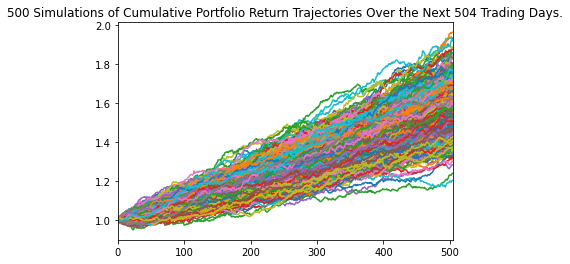

In [67]:
line_plot_low=MC_low_vol.plot_simulation()

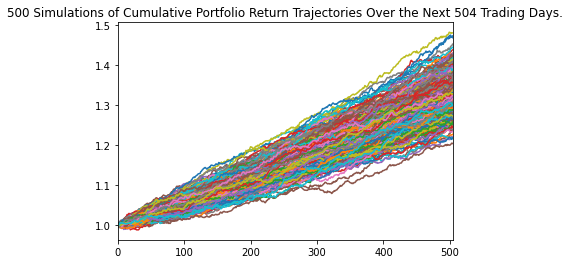

In [68]:
line_plot_high=MC_high_vol.plot_simulation()

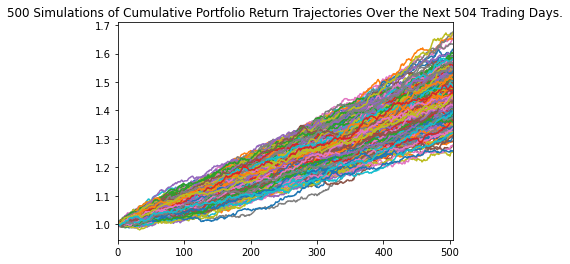

In [69]:
line_plot_rand=MC_rand_port.plot_simulation()

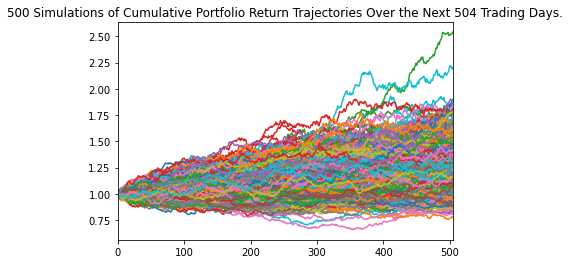

In [70]:
line_plot_index=MC_index_port.plot_simulation()

In [71]:
##Calculating portfolio returns for each option and return on a $10,000 invesment, specifically cumulative returns and the value of a $10,000 investment
#Starting first with low beta portfolio
initial_investment_low = 10000
weights = [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]

low_vol_returns = low_vol.pct_change().dropna()
low_vol_returns.head()

,NEM,NFLX,AMD,VRTX,ABMD,BBY,MNST,INCY,TMUS,FCX,...,PRGO,IPGP,ALXN,TSN,OKE,AKAM,JNPR,DVN,HCA,URI
2012-01-04 00:00:00,-0.003061,0.113649,-0.003650,-0.000931,-0.007671,-0.019003,0.000973,-0.014009,-0.063898,0.008354,...,-0.035109,0.016983,-0.003968,0.002954,-0.000801,-0.014880,-0.013783,-0.011042,-0.038817,0.028315
2012-01-05 00:00:00,0.003393,-0.014295,0.000000,0.028571,0.008835,0.009040,0.013716,0.045332,-0.088737,-0.013307,...,0.011147,0.056777,0.030161,-0.004418,0.001030,-0.000308,-0.005301,-0.000153,0.023558,0.005037
2012-01-06 00:00:00,-0.002093,0.088146,-0.005495,0.028080,-0.007116,0.033276,0.016194,0.055016,0.001248,-0.010941,...,-0.000936,0.020806,0.028173,0.001972,-0.002630,0.010176,-0.010174,-0.009485,0.049319,-0.010023
2012-01-09 00:00:00,-0.007907,0.137791,0.029466,0.047871,0.003859,0.016515,0.005662,-0.001227,0.022444,0.004374,...,0.005205,0.017028,-0.002418,-0.011319,-0.005160,-0.004579,0.053842,0.016834,-0.030886,-0.005400
2012-01-10 00:00:00,0.019031,-0.023936,0.021467,0.017937,-0.002746,0.004062,-0.006985,-0.013514,0.012195,0.039959,...,0.031276,0.203196,0.005520,0.011946,0.016136,0.016253,-0.008825,-0.002126,0.037413,0.065830


/Users/keirangugula/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/pandas/plotting/_converter.py:278: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0E9)


<AxesSubplot:>

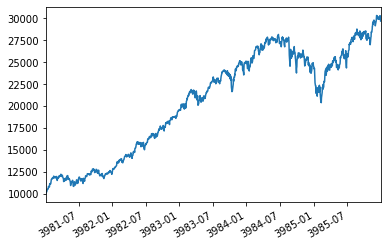

In [80]:
low_vol_combined = low_vol_returns.dot(weights)
low_vol_cumulative = (1 + low_vol_combined).cumprod()
low_vol_profit = initial_investment_low * low_vol_cumulative
low_vol_profit.plot()

In [81]:
#Calculating portfolio metrics for high beta portfolio, specifically cumulative returns and the value of a $10,000 investment
initial_investment_high = 10000
weights = [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]

high_vol_returns = high_vol.pct_change().dropna()
high_vol_returns.head()

,AME,PNC,NOC,MCD,XRAY,CTAS,PGR,HSIC,GD,PG,...,AJG,CB,GL,L,CINF,JNJ,ADP,MMM,MMC,SPY
2012-01-04 00:00:00,0.013728,0.003219,-0.000511,0.005565,-0.000283,0.032917,-0.004137,-0.003041,0.001765,-0.000449,...,-0.015921,-0.009526,-0.006630,-0.012217,-0.004902,-0.006072,-0.001102,0.008264,-0.011314,0.001569
2012-01-05 00:00:00,0.016577,0.009963,-0.008187,0.004427,0.000848,0.003022,0.008827,0.010067,-0.010570,-0.004192,...,0.002442,0.002871,0.012198,0.001316,0.014121,-0.001222,0.007353,-0.004514,-0.009854,0.002662
2012-01-06 00:00:00,-0.011943,0.001672,-0.004299,0.007713,-0.005932,0.021912,0.004117,-0.001359,0.003264,-0.002405,...,0.002132,0.002433,-0.011824,-0.008673,-0.006800,-0.008716,0.001460,-0.005131,-0.013804,-0.002577
2012-01-09 00:00:00,0.000232,0.008179,0.000173,-0.009543,-0.004831,0.002144,0.002050,-0.003629,0.011091,0.004219,...,0.001519,0.004569,-0.002301,0.003181,0.009129,0.001542,-0.003827,0.005997,0.002279,0.002427
2012-01-10 00:00:00,0.023240,0.019371,0.012260,0.000602,0.014278,0.017384,0.003581,0.012293,0.022817,-0.004652,...,0.001517,0.006397,0.012223,0.016913,0.011955,0.004158,-0.000183,0.005127,0.007795,0.008671


/Users/keirangugula/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/pandas/plotting/_converter.py:278: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0E9)


<AxesSubplot:>

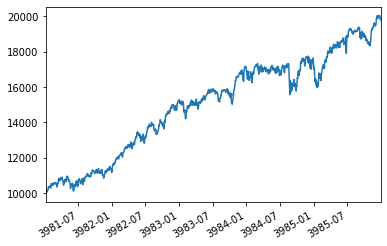

In [82]:
high_vol_combined = high_vol_returns.dot(weights)
high_vol_cumulative = (1 + high_vol_combined).cumprod()
high_vol_profit = initial_investment_high * high_vol_cumulative
high_vol_profit.plot()

In [83]:
#Calculating portfolio metrics for index portfolio (use ETF SPY as a proxy), specifically cumulative returns and the value of a $10,000 investment
initial_investment_index = 10000

index_port_returns = index_port.pct_change().dropna()
index_port_returns.head()

,SPY
Date,
2012-01-04,0.001569
2012-01-05,0.002662
2012-01-06,-0.002577
2012-01-09,0.002427
2012-01-10,0.008671


/Users/keirangugula/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/pandas/plotting/_converter.py:278: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0E9)


<AxesSubplot:xlabel='Date'>

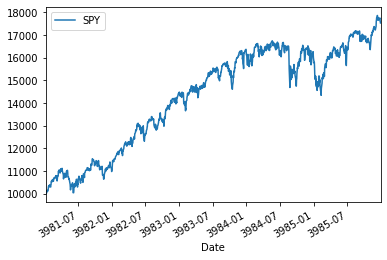

In [84]:
index_port_cumulative = (1 + index_port_returns).cumprod()
index_port_profit = initial_investment_index * index_port_cumulative
index_port_profit.plot()

In [85]:
#Calculating portfolio metrics for randomly selected portfolio, specifically cumulative returns and the value of a $10,000 investment
initial_investment_rand = 10000
weights = [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]

rand_port_returns = rand_port.pct_change().dropna()
rand_port_returns.head()

,AVGO,PNW,AIZ,RF,CCI,CHTR,USB,KMB,INTC,EBAY,...,MCO,CSX,COO,JNPR,GLW,DISH,WY,MTD,TAP,ATO
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-04,-0.017271,-0.006690,-0.012298,-0.002299,0.002226,-0.006644,-0.000363,-0.003141,0.023227,-0.037652,...,-0.002560,0.028131,-0.000706,-0.013783,0.009969,0.013416,-0.010995,-0.001312,-0.008937,-0.005128
2012-01-05,0.001406,0.000632,0.006592,0.041475,-0.000889,0.002992,0.014871,-0.002740,0.011549,0.018236,...,0.017679,0.004413,-0.008908,-0.005301,0.008352,0.002376,-0.005823,0.011302,0.003468,-0.003942
2012-01-06,-0.006318,-0.003155,-0.001455,-0.024336,0.001556,-0.006318,-0.008220,-0.002198,-0.005905,-0.002605,...,0.003923,-0.003076,-0.004423,-0.010174,0.018072,-0.026752,0.012780,0.009421,0.003917,-0.006088
2012-01-09,0.067467,-0.005064,-0.007773,0.027211,0.012875,0.002296,0.017658,0.001102,0.008713,-0.003918,...,0.000000,0.014985,-0.008455,0.053842,0.016272,0.001740,-0.012093,0.005085,0.004590,-0.008270
2012-01-10,0.014229,0.013998,-0.007834,0.037528,0.010958,-0.001586,0.000708,0.002338,0.004711,0.022616,...,0.013955,0.021711,0.005059,-0.008825,0.018195,0.003126,0.022352,0.035351,0.020334,-0.003397


/Users/keirangugula/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/pandas/plotting/_converter.py:278: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0E9)


<AxesSubplot:xlabel='Date'>

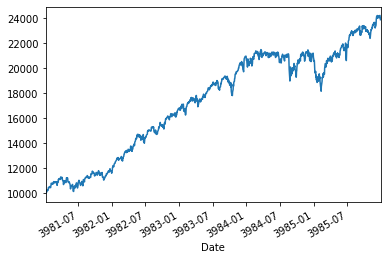

In [86]:
rand_port_combined = rand_port_returns.dot(weights)
rand_port_cumulative = (1 + rand_port_combined).cumprod()
rand_port_profit = initial_investment_rand * rand_port_cumulative
rand_port_profit.plot()

In [87]:
#Plotting using hv plot, the cumulative value of an initial investment of $10K in each of the portfolios over time
low_vol_plot = low_vol_profit.hvplot(label='Low Beta Portfolio')
high_vol_plot = high_vol_profit.hvplot(label='High Beta Portfolio')
rand_port_plot = rand_port_profit.hvplot(label="Randomly Selected Portfolio")
index_plot = index_port_profit.hvplot(label="Index Portfolio (Base Case)")

index_plot + low_vol_plot + high_vol_plot + rand_port_plot

:Layout
   .Curve.Index_Portfolio_left_parenthesis_Base_Case_right_parenthesis :Curve   [Date]   (SPY)
   .Curve.Low_Beta_Portfolio                                           :Curve   [index]   (0)
   .Curve.High_Beta_Portfolio                                          :Curve   [index]   (0)
   .Curve.Randomly_Selected_Portfolio                                  :Curve   [Date]   (0)

In [88]:
# Calculating sharpe ratios for each portfolio in order to determine risk adjusted return
# Sharpe ratio of low beta portfolio
low_sharpe = (low_vol_combined.mean() * 252) / (low_vol_combined.std() * np.sqrt(252))
low_sharpe

1.3489294509090966

In [89]:
# Sharpe ratio of high beta portfolio
high_sharpe = (high_vol_combined.mean() * 252) / (high_vol_combined.std() * np.sqrt(252))
high_sharpe

1.1906534146672538

In [90]:
# Sharpe ratio of index portfolio
index_sharpe = (index_port_returns.mean() * 252) / (index_port_returns.std() * np.sqrt(252))
index_sharpe

SPY    0.939578
dtype: float64

In [91]:
# Sharpe ratio of randomly selected portfolio
rand_sharpe = (rand_port_combined.mean() * 252) / (rand_port_combined.std() * np.sqrt(252))
rand_sharpe

1.35899193785421

In [92]:
# Creating a dataframe combinging all four portfolio returns, joined on a common index of date
combined_port_returns = pd.concat(
    [low_vol_combined, high_vol_combined, rand_port_combined, index_port_returns], axis=1, join="inner"
)
combined_port_returns

,0,1,2,SPY
2012-01-04,0.000170,-0.002112,-0.003260,0.001569
2012-01-05,0.009087,0.003155,0.006148,0.002662
2012-01-06,0.005432,-0.001891,-0.000274,-0.002577
2012-01-09,0.004706,0.002766,0.004552,0.002427
2012-01-10,0.016241,0.010182,0.013238,0.008671
2012-01-11,0.006194,0.000756,0.002596,0.000542
2012-01-12,0.006116,0.005150,0.004336,0.002399
2012-01-13,-0.002287,-0.004683,-0.007883,-0.005173
2012-01-17,0.005542,0.004384,0.002482,0.003881
2012-01-18,0.020176,0.009520,0.014067,0.011056


/Users/keirangugula/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/pandas/plotting/_converter.py:278: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0E9)
/Users/keirangugula/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/pandas/plotting/_converter.py:278: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0E9)
/Users/keirangugula/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/pandas/plotting/_converter.py:278: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0E9)
/Users/keirangugula/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/pandas/plotting/_converter.py:278: MatplotlibDeprecationWarning: 


<AxesSubplot:>

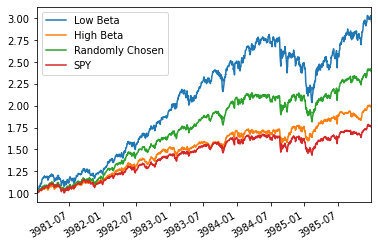

In [93]:
# Calculating cumulative returns for each of the four portfolios and plotting results
combined_port_returns.rename(columns={0: "Low Beta", 1 : "High Beta", 2: "Randomly Chosen"}, inplace=True)
cumulative_port_returns = (1 + combined_port_returns).cumprod()
cumulative_port_returns.plot()

In [94]:
# Calculating the correlation of daily returns among the four different portfolios and visualizsing via seaborn heatmap
correlation = combined_port_returns.corr()
correlation

,Low Beta,High Beta,Randomly Chosen,SPY
Low Beta,1.000000,0.826846,0.899744,0.889593
High Beta,0.826846,1.000000,0.943786,0.960667
Randomly Chosen,0.899744,0.943786,1.000000,0.962686
SPY,0.889593,0.960667,0.962686,1.000000


<AxesSubplot:>

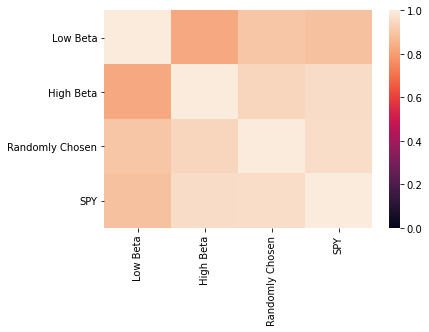

In [95]:
sns.heatmap(correlation, vmin=-0, vmax=1)